<a href="https://colab.research.google.com/github/vysf/seismologi-terapan/blob/master/Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tujuan


1.   Melakukan Preadjustment instrument
2.   Menyaring time window berdasarkan deteksi kejadian



In [1]:
!pip install obspy

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import obspy
from obspy.signal.trigger import recursive_sta_lta, trigger_onset
import pickle

In [3]:
observed_file = "HAGI_16.mseed"

In [4]:
stream = obspy.read(observed_file)
print(stream)

3 Trace(s) in Stream:
HG.16..BHE | 2022-07-28T05:37:02.340000Z - 2022-07-28T08:00:09.130000Z | 100.0 Hz, 858680 samples
HG.16..BHN | 2022-07-28T05:37:02.390000Z - 2022-07-28T07:59:43.400000Z | 100.0 Hz, 856102 samples
HG.16..BHZ | 2022-07-28T05:37:02.800000Z - 2022-07-28T07:59:45.620000Z | 100.0 Hz, 856283 samples


In [5]:
print(stream[0].stats)

         network: HG
         station: 16
        location: 
         channel: BHE
       starttime: 2022-07-28T05:37:02.340000Z
         endtime: 2022-07-28T08:00:09.130000Z
   sampling_rate: 100.0
           delta: 0.01
            npts: 858680
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 7533, 'encoding': 'FLOAT32', 'byteorder': '>', 'record_length': 512, 'filesize': 11548160})


## Processing

In [6]:
def visualizes(stream, suptitle, trim=False, windows=[], **kwargs):
  """
  Melakukan plot trace seismik

  Parameter
  ---------
  stream : list[obspy.core.trace.Trace]
    file seismik.

  suptitle : str
    judul plot.

  trim : bool
    menampilkan rentang data yang akan di trim

  windows : list[(start_window, end_window, window_id)]
    daftar time window

  kwrags: dict
    timestart: waktu mulai
    datalength: panjang data
  """

  fig, ax = plt.subplots(3, 1, figsize=(16, 8), dpi=75, sharex=True)
  fig.suptitle(suptitle)

  for i, trace in enumerate(stream):
    time = trace.times()
    data = trace.data

    ax[i].plot(time, data)
    ax[i].set_title(trace.stats.channel[-1])
    ax[i].set_ylabel("amplitude")
    ax[i].set_xlim(min(time),max(time))
    ax[i].grid()
    if i == len(stream)-1:
      ax[i].set_xlabel("time (second)")

    if trim:
      ax[i].axvspan(kwargs['timestart'],
                    kwargs['timestart']+kwargs['datalength'],
                    color='green',
                    alpha=0.6)

    if len(windows):
      for start_window, end_window, _ in windows:
        ax[i].axvspan(start_window-trace.stats.starttime,
                      end_window-trace.stats.starttime,
                      facecolor='green',
                      edgecolor='k',
                      alpha=0.3)

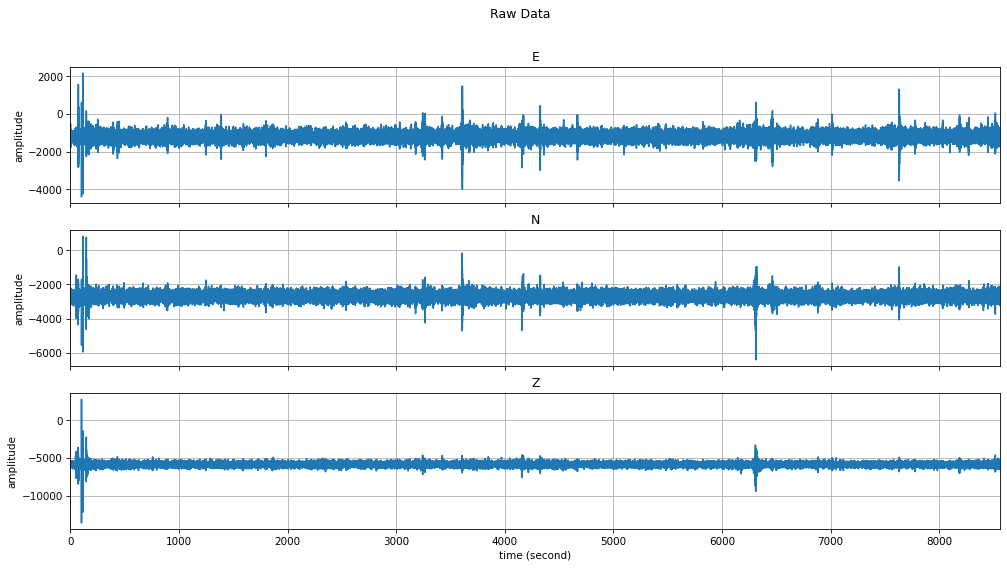

In [7]:
visualizes(stream, "Raw Data")

### Detrend

Baseline correction menggunakan detrend

In [8]:
baseline_correction_method = "demean" # simple, linear, constant/demean, polynomial, spline

In [9]:
stream01 = stream.copy()
for trace in stream01:
    trace.detrend(baseline_correction_method)

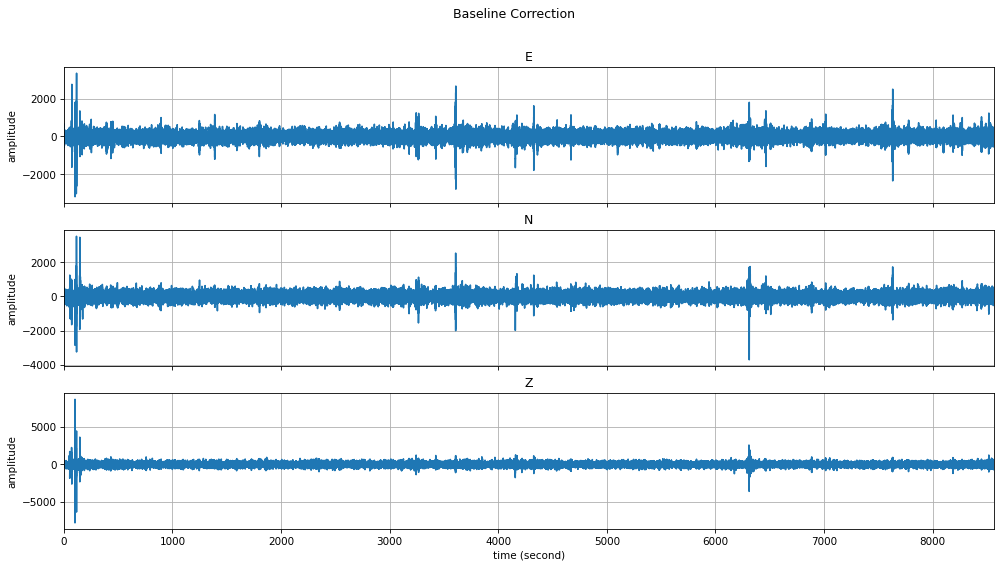

In [10]:
visualizes(stream01, "Baseline Correction")

### Preadjustment

In [11]:
adjustment_E = 1
adjustment_N = 1
adjustment_Z = 1

adjustments = [adjustment_E, adjustment_N, adjustment_Z]

In [12]:
def preadjustment(trace, adjustment):
  """
  menghitung data preadjustment
  .. math::
    f^*(t)=\int_{-\omega}^{\omega}\int_{-\omega}^{\omega} (f(t) e^{-i\omega t} dt ) . \alpha(f) e^{i\omega t} d\omega

  Parameters
  ---------
  trace : obspy.core.trace.Trace
    trace seismik.

  adjustment : int or float
    faktor adjustment.

  Returns
  ---------
  preadjusted: ndarray
    hasil hitungan data preadjustment
  """
  transform_trace = np.fft.fft(trace.data)

  magnitude = np.abs(transform_trace)
  adjustment_factor_cal = magnitude * adjustment

  theta = np.angle(transform_trace) # omega*time

  invers_transform = np.fft.ifft(adjustment_factor_cal * np.exp(1j * theta))

  preadjusted = np.real(invers_transform)
  return preadjusted

In [13]:
stream02 = stream01.copy()
for trace, adjustment in zip(stream02, adjustments):
  trace.data = preadjustment(trace, adjustment)

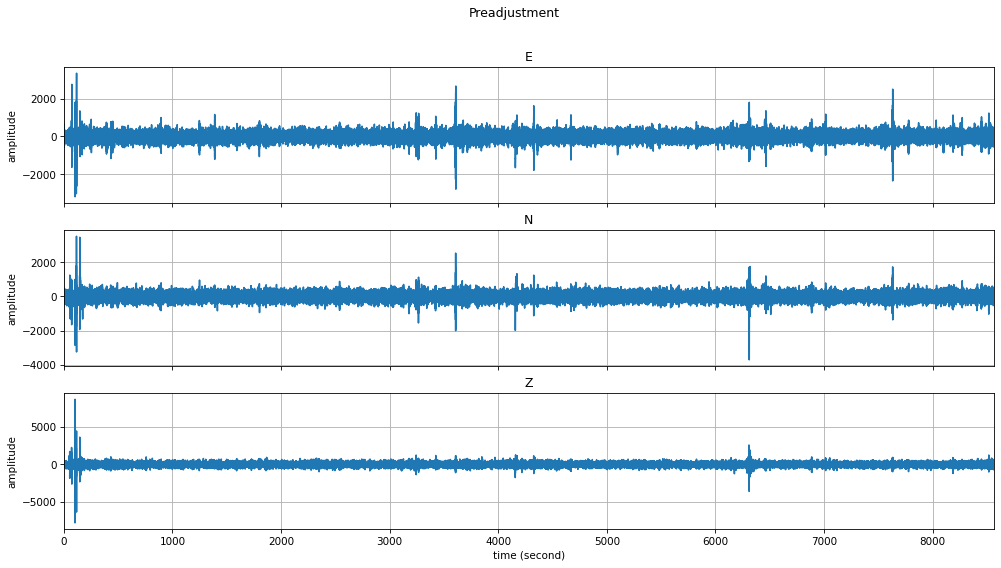

In [14]:
visualizes(stream02, "Preadjustment")

### Frequency Filtering

In [15]:
freqmin = 1.5
freqmax = 4.5

In [16]:
stream03 = stream02.copy()
for trace in stream03:
  trace.filter("bandpass", freqmin=freqmin, freqmax=freqmax, zerophase=True)

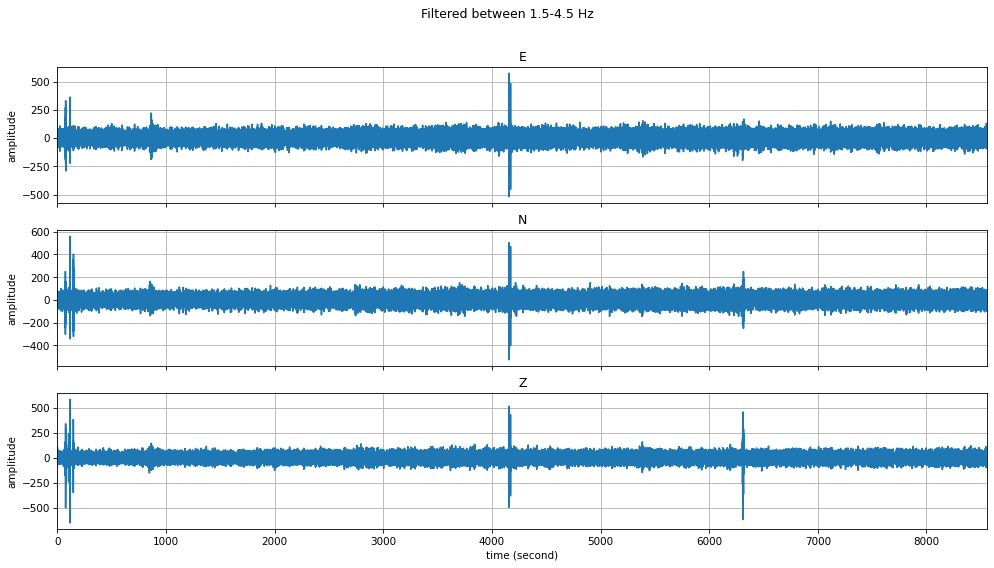

In [17]:
visualizes(stream03, f"Filtered between {freqmin}-{freqmax} Hz")

### Time Trimming

In [18]:
timestart = 1000 # the first x seconds will be discarded
datalength = 4500 # in seconds

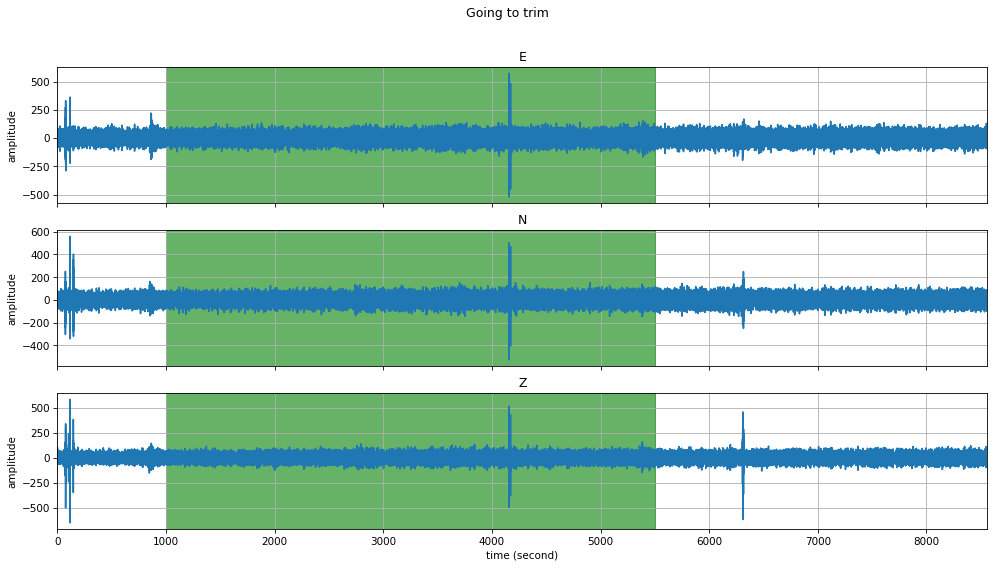

In [19]:
visualizes(stream03, "Going to trim", trim=True, timestart=timestart, datalength=datalength)

In [20]:
stream04 = stream03.copy()
stream04.trim(stream03[0].stats.starttime+timestart,stream03[0].stats.starttime+timestart+datalength)

3 Trace(s) in Stream:
HG.16..BHE | 2022-07-28T05:53:42.340000Z - 2022-07-28T07:08:42.340000Z | 100.0 Hz, 450001 samples
HG.16..BHN | 2022-07-28T05:53:42.340000Z - 2022-07-28T07:08:42.340000Z | 100.0 Hz, 450001 samples
HG.16..BHZ | 2022-07-28T05:53:42.340000Z - 2022-07-28T07:08:42.340000Z | 100.0 Hz, 450001 samples

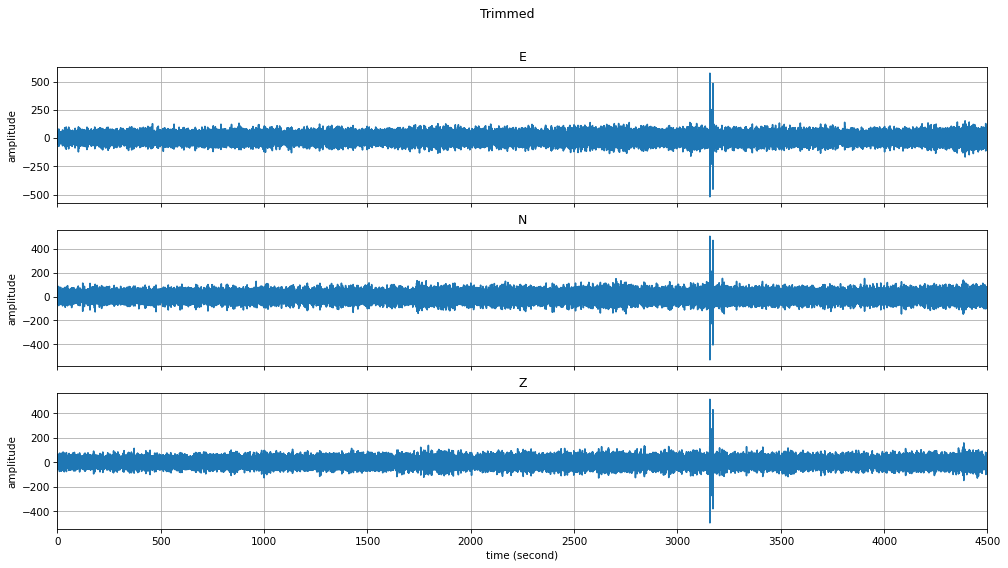

In [21]:
visualizes(stream04, "Trimmed")

### Save the trimmed data

In [22]:
stream04.write('temporary_prepro.mseed',format="MSEED")

/usr/local/lib/python3.10/dist-packages/obspy/io/mseed/core.py:770: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


In [23]:
window_length = 10 # seconds

In [24]:
def get_windows(starttime, endtime, window_length):
  """
  windowing trace seismik

  Parameters
  ---------
  starttime : obspy.core.UTCDateTime
    waktu mulai.

  endtime : obspy.core.UTCDateTime
    waktu selesai.

  window_length : bool
    panjang window (sekon)

  Returns
  ---------
  window_list: list[(start_window,end_window,window_id)]
    kumpulan window mulai, window akhir, dan id window per window_length
  """

  start_window = starttime
  end_window = starttime + window_length
  window_list = []
  window_id = 0
  while end_window < endtime:
    window_list.append((start_window,end_window,window_id))
    start_window += window_length
    end_window += window_length
    window_id += 1
  return window_list

### Time Windowing

In [25]:
starttime = stream04[0].stats.starttime
endtime = stream04[0].stats.endtime

window_list = get_windows(starttime, endtime, window_length)

print(f"{len(window_list)} windows has been created! Total {len(window_list)*window_length/60:5.2f} minutes")

449 windows has been created! Total 74.83 minutes


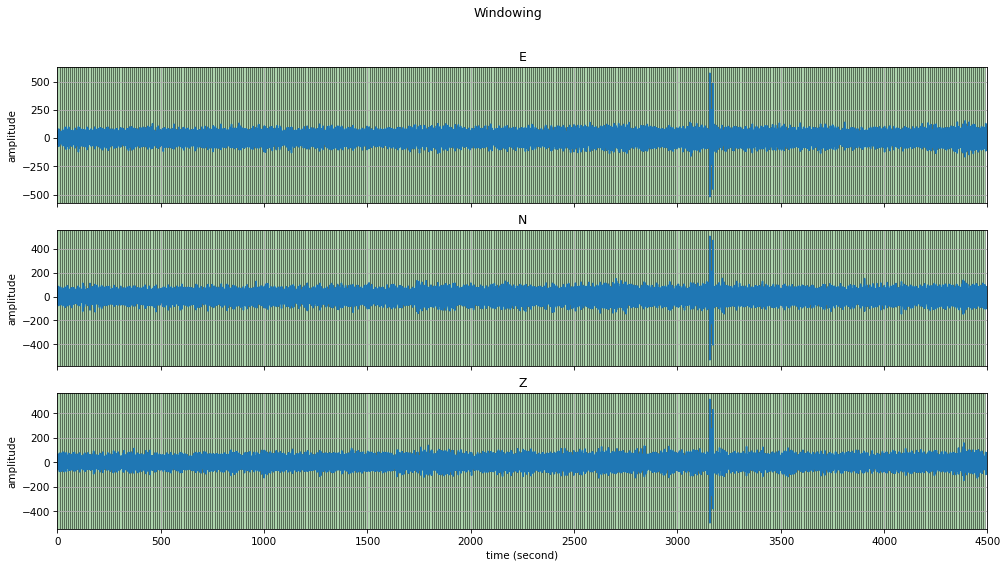

In [26]:
visualizes(stream04, "Windowing", windows=window_list)

### Transient Event Detection

In [27]:
nsta = 1 # in seconds
nlta = 20 # in seconds
trigger_on = 2.5
trigger_off = 1.25

In [28]:
stalta_list = []
for trace in stream04:
  fs = trace.stats.sampling_rate
  stalta_list.append(recursive_sta_lta(trace, int(nsta * fs), int(nlta * fs)))

In [29]:
print(np.array(stalta_list))

[[0.         0.         0.         ... 0.57386691 0.58435034 0.6007792 ]
 [0.         0.         0.         ... 0.49322154 0.49285311 0.49074305]
 [0.         0.         0.         ... 0.54767851 0.5477228  0.54884299]]


In [30]:
def visualizes_event_detection(stream, stalta_list, trigger_on, trigger_off):
  """
  Melakukan plot trace seismik

  Parameters
  ---------
  stream : list[obspy.core.trace.Trace]
    file seismik.

  stalta_list : list[stalta]
    daftar stalta tiga komponen [stalta_E, stalta_N, stalta_Z].

  trigger_on : float
    trigger mulai

  trigger_off : float
    trigger selesai
  """
  labels = ['STA/LTA E','STA/LTA N','STA/LTA Z']
  fig,ax = plt.subplots(3,1,figsize=(16,12), dpi=75, sharex=True)

  for i, (trace, stalta, labely) in enumerate(zip(stream, stalta_list, labels)):
    time = trace.times()
    ax[i].plot(time,stalta,lw=0.5)
    ax[i].plot([time[0] ,time[-1]], [trigger_on, trigger_on], '-.r', label="trigger ON")
    ax[i].plot([time[0], time[-1]], [trigger_off, trigger_off], '-.g', label="trigger OFF")
    ax[i].set_ylim(0,4)
    ax[i].set_ylabel(labely)
    ax[i].set_xlim(min(time), max(time))
    ax[i].legend()

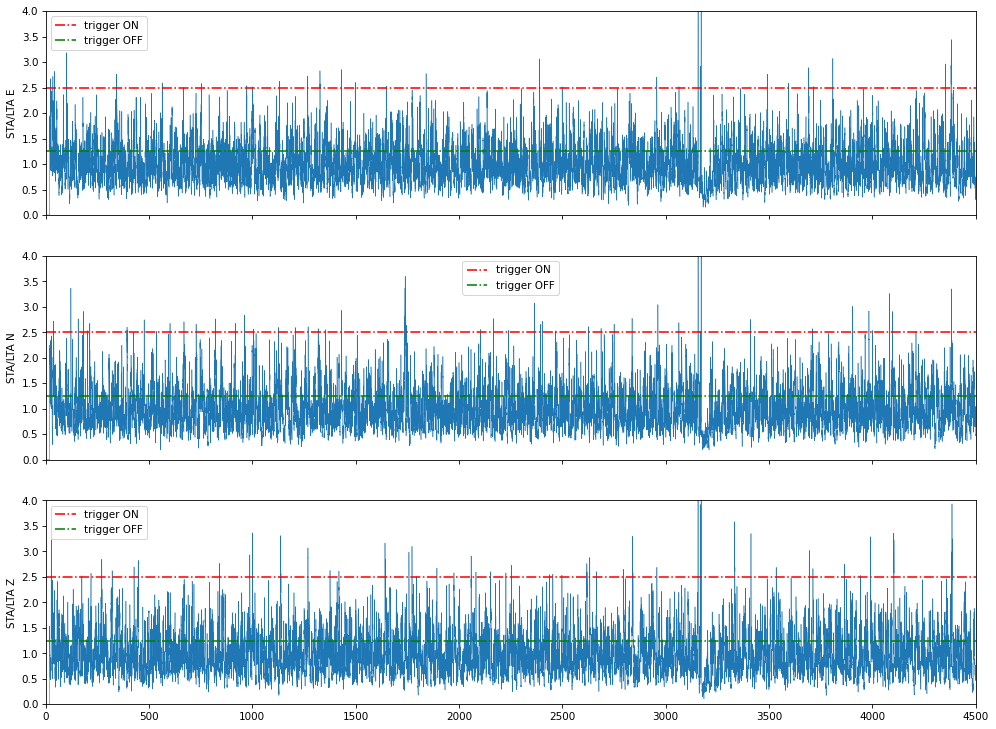

In [31]:
visualizes_event_detection(stream04, stalta_list, trigger_on, trigger_off)

### Filter The Time Window Based on Event Detection

In [32]:
def get_trigger_index(trace, windows, on_off):
  """
  mendapatkan index trigger

  Parameters
  ----------
  trace : obspy.core.trace.Trace
    trace seismik

  windows: list[(start_window,end_window,window_id)]
    kumpulan window mulai, window akhir, dan id window per window_length

  on_off : ndarray[list[start trigger, end trigger]]
    kumpulan data triger mulai dan triger selesai komponen Z

  Returns
  -------
  badwindow: list[int]
    daftar index untuk window yang terjadi trigger
  """
  badwindow = []
  lastWindowIndex = -1

  for item in on_off:
    on_trigger = item[0]
    off_trigger = item[-1]
    triggered = False

    start_trigger = trace.stats.starttime + on_trigger/trace.stats.sampling_rate
    end_trigger = trace.stats.starttime + off_trigger/trace.stats.sampling_rate

    for idx, (start_window, end_window, _) in enumerate(windows):
      if(idx > lastWindowIndex):
        if(start_trigger > start_window and start_trigger < end_window and not triggered):
          triggered = True
          badwindow.append(idx)
          lastWindowIndex = idx
        elif(end_trigger > end_window and triggered):
          badwindow.append(idx)
          lastWindowIndex = idx
        elif(end_trigger < end_window and triggered):
          badwindow.append(idx)
          lastWindowIndex = idx
          triggered = False
          break
  badwindow.reverse()
  return badwindow

In [33]:
window_list01 = window_list.copy()
on_off = []

for trace, stalta in zip(stream04, stalta_list):
  on_off.append(trigger_onset(stalta, trigger_on, trigger_off))

  on_off_z = on_off[-1]
  badwindow = get_trigger_index(trace, window_list01, on_off_z)
  for idx in badwindow:
    window_list01.pop(idx)

In [34]:
print(f"{len(window_list01)} windows left! Total {len(window_list01)*window_length/60:5.2f} minutes")

with open('window_list_prepro.pkl','wb') as fo:
  pickle.dump(window_list01, fo)

273 windows left! Total 45.50 minutes


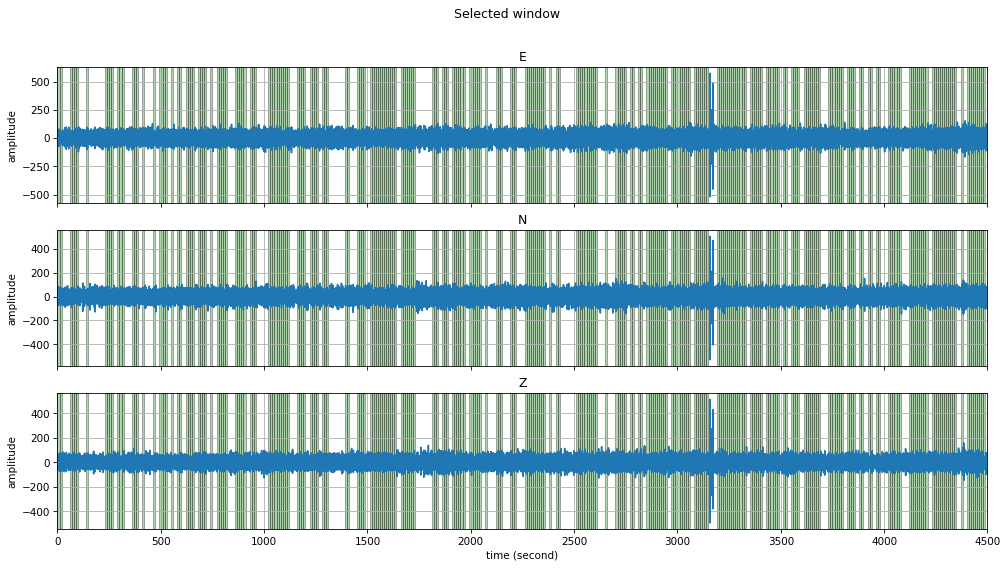

In [35]:
visualizes(stream04, "Selected window", windows=window_list01)

## Save the result

Simpan dan downloadlah file:


1.   `temporary_prepro.mseed`
2.   `window_list_prepro.pkl`

File diatas akan digunakan pada proses pengolahan selanjutnya

